In [1]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# 1(a): Create Frozen Lake Environment

env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode=None)
print(f"Environment created successfully!")
print(f"Action space: {env.action_space}")
print(f"State space: {env.observation_space}")
print(f"Grid size: 4x4 (16 states)")

=== Task 1(a): Creating Frozen Lake Environment ===
Environment created successfully!
Action space: Discrete(4)
State space: Discrete(16)
Grid size: 4x4 (16 states)


In [3]:
# 1(b): Collect data from 10,000 episodes

def calculate_goal_proximity(state, goal_state=15):
    """Calculate Manhattan distance to goal state"""
    state_row, state_col = divmod(state, 4)
    goal_row, goal_col = divmod(goal_state, 4)
    return abs(state_row - goal_row) + abs(state_col - goal_col)

def collect_episode_data(env, episodes=10000):
    """Collect data from random agent episodes"""
    data = []
    successful_episodes = 0

    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        episode_data = []

        for step in range(100):  # Max steps per episode
            action = env.action_space.sample()  # Random action
            goal_proximity = calculate_goal_proximity(state)

            next_state, reward, done, truncated, _ = env.step(action)
            total_reward += reward

            # Record observation
            episode_data.append({
                'episode': episode,
                'step': step,
                'state': state,
                'action': action,
                'reward': reward,
                'total_reward': total_reward,
                'goal_proximity': goal_proximity,
                'next_state': next_state,
                'done': done
            })

            state = next_state

            if done:
                if reward > 0:  # Reached goal
                    successful_episodes += 1
                break

        # Update total reward for all steps in this episode
        for data_point in episode_data:
            data_point['episode_total_reward'] = total_reward

        data.extend(episode_data)

        if (episode + 1) % 2000 == 0:
            print(f"Completed {episode + 1} episodes...")

    return pd.DataFrame(data), successful_episodes

In [4]:
# Collect the data
df, successful_episodes = collect_episode_data(env, 10000)
print(f"Data collection completed!")
print(f"Total data points: {len(df)}")
print(f"Successful episodes: {successful_episodes}")

Completed 2000 episodes...
Completed 4000 episodes...
Completed 6000 episodes...
Completed 8000 episodes...
Completed 10000 episodes...
Data collection completed!
Total data points: 76606
Successful episodes: 145


In [5]:
# 1(c): Calculate proportion of successful episodes

success_rate = successful_episodes / 10000
print(f"Success rate: {success_rate:.4f} ({success_rate*100:.2f}%)")

Success rate: 0.0145 (1.45%)


In [6]:
# 1(d): Create state-action value

def calculate_state_action_value(df):
    """Calculate importance of each state-action pair"""
    # Method 1: Based on future rewards and goal proximity
    df['future_reward_potential'] = df.groupby('episode')['reward'].transform(
        lambda x: x.iloc[::-1].cumsum()[::-1]
    )

    # Method 2: Inverse goal proximity (closer to goal = higher value)
    df['proximity_value'] = 1 / (df['goal_proximity'] + 1)

    # Method 3: Success-weighted value
    episode_success = df.groupby('episode')['episode_total_reward'].first()
    df['episode_success'] = df['episode'].map(episode_success)

    # Combined state-action value
    df['state_action_value'] = (
        0.4 * df['future_reward_potential'] +
        0.3 * df['proximity_value'] +
        0.3 * df['episode_success']
    )

    return df

df = calculate_state_action_value(df)
print("State-action values calculated successfully!")

State-action values calculated successfully!


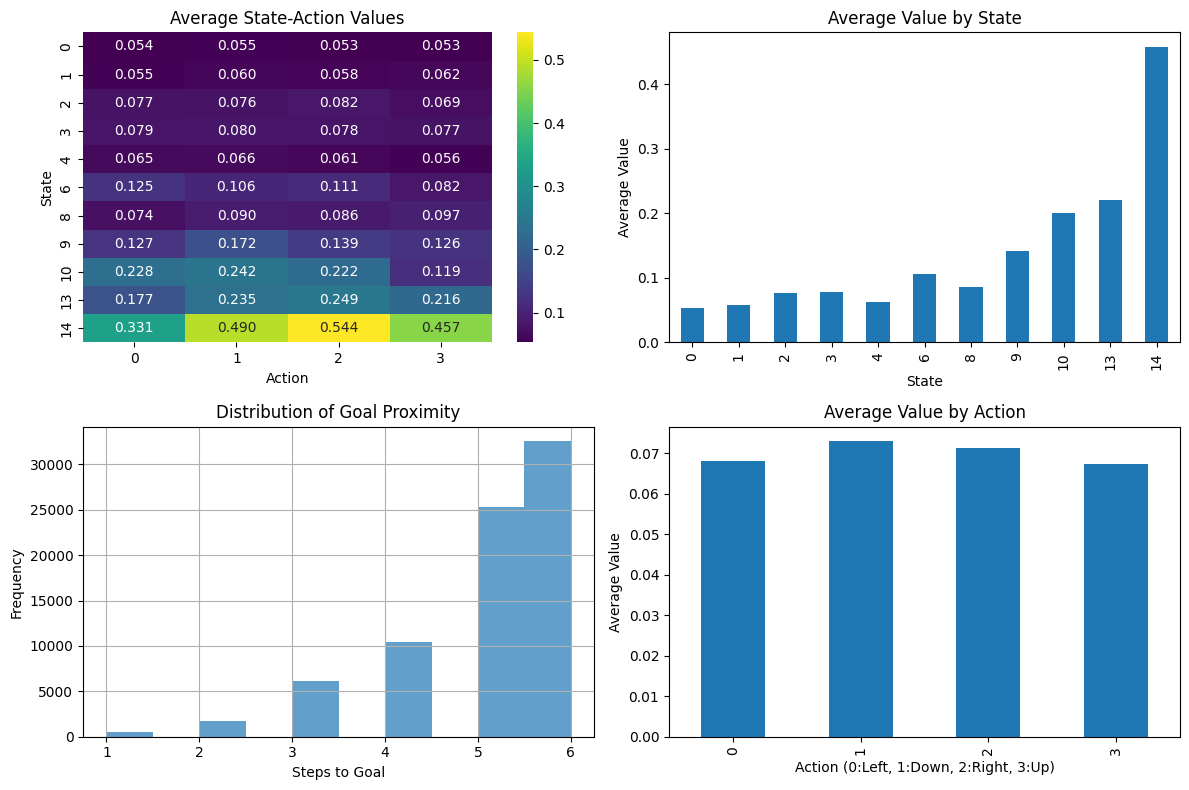

In [7]:
# Visualize state-action values

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
state_action_avg = df.groupby(['state', 'action'])['state_action_value'].mean().reset_index()
pivot_table = state_action_avg.pivot(index='state', columns='action', values='state_action_value')
sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt='.3f')
plt.title('Average State-Action Values')
plt.xlabel('Action')
plt.ylabel('State')

plt.subplot(2, 2, 2)
df.groupby('state')['state_action_value'].mean().plot(kind='bar')
plt.title('Average Value by State')
plt.xlabel('State')
plt.ylabel('Average Value')

plt.subplot(2, 2, 3)
df['goal_proximity'].hist(bins=10, alpha=0.7)
plt.title('Distribution of Goal Proximity')
plt.xlabel('Steps to Goal')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
df.groupby('action')['state_action_value'].mean().plot(kind='bar')
plt.title('Average Value by Action')
plt.xlabel('Action (0:Left, 1:Down, 2:Right, 3:Up)')
plt.ylabel('Average Value')

plt.tight_layout()
plt.show()

In [8]:
# 1(e): Train ML model to predict state-action values

# Prepare features
features = ['state', 'action', 'goal_proximity', 'step']
X = df[features]
y = df['state_action_value']

# Add some feature engineering
X['state_action_interaction'] = X['state'] * 4 + X['action']
X['proximity_action_interaction'] = X['goal_proximity'] * X['action']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train multiple models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Linear Regression': LinearRegression()
}

model_results = {}
trained_models = {}

for name, model in models.items():
    if name == 'Linear Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    model_results[name] = {'MSE': mse, 'R2': r2}
    trained_models[name] = model

    print(f"{name}:")
    print(f"  MSE: {mse:.4f}")
    print(f"  R²: {r2:.4f}")

# Select best model
best_model_name = max(model_results.keys(), key=lambda k: model_results[k]['R2'])
best_model = trained_models[best_model_name]
print(f"\nBest model: {best_model_name}")

Random Forest:
  MSE: 0.0123
  R²: 0.1226
Linear Regression:
  MSE: 0.0127
  R²: 0.0958

Best model: Random Forest


In [9]:
# 1(f): Implement algorithm using the trained model

class MLGuidedAgent:
    def __init__(self, model, scaler=None, model_name='Random Forest'):
        self.model = model
        self.scaler = scaler
        self.model_name = model_name

    def predict_action_values(self, state, step=0):
        """Predict values for all actions in given state"""
        goal_proximity = calculate_goal_proximity(state)

        action_values = []
        for action in range(4):  # 4 possible actions
            features = np.array([[state, action, goal_proximity, step,
                                state * 4 + action, goal_proximity * action]])

            if self.scaler and self.model_name == 'Linear Regression':
                features = self.scaler.transform(features)

            value = self.model.predict(features)[0]
            action_values.append(value)

        return action_values

    def select_action(self, state, step=0, epsilon=0.0):
        """Select action based on predicted values"""
        if np.random.random() < epsilon:
            return np.random.randint(4)  # Random action (exploration)

        action_values = self.predict_action_values(state, step)
        return np.argmax(action_values)  # Greedy action (exploitation)

# Create guided agent
if best_model_name == 'Linear Regression':
    guided_agent = MLGuidedAgent(best_model, scaler, best_model_name)
else:
    guided_agent = MLGuidedAgent(best_model, model_name=best_model_name)

def evaluate_agent(agent, episodes=10000, epsilon=0.0):
    """Evaluate agent performance"""
    successes = 0
    total_steps = 0
    episode_lengths = []

    for episode in range(episodes):
        state, _ = env.reset()
        steps = 0

        for step in range(100):  # Max steps
            action = agent.select_action(state, step, epsilon)
            state, reward, done, truncated, _ = env.step(action)
            steps += 1

            if done:
                if reward > 0:
                    successes += 1
                episode_lengths.append(steps)
                total_steps += steps
                break
        else:
            episode_lengths.append(100)  # Max steps reached
            total_steps += 100

    success_rate = successes / episodes
    avg_steps = total_steps / episodes

    return {
        'success_rate': success_rate,
        'avg_steps': avg_steps,
        'total_successes': successes,
        'episode_lengths': episode_lengths
    }

In [10]:
# 1(g): Evaluate performance

results_basic = evaluate_agent(guided_agent, 10000)

print(f"Basic Algorithm Results (10,000 episodes):")
print(f"Success Rate: {results_basic['success_rate']:.4f} ({results_basic['success_rate']*100:.2f}%)")
print(f"Average Steps: {results_basic['avg_steps']:.2f}")
print(f"Total Successes: {results_basic['total_successes']}")

Basic Algorithm Results (10,000 episodes):
Success Rate: 0.0466 (4.66%)
Average Steps: 8.34
Total Successes: 466


In [11]:
# 1(h): Improve with exploration-exploitation

class ImprovedMLAgent(MLGuidedAgent):
    def __init__(self, model, scaler=None, model_name='Random Forest',
                 initial_epsilon=0.3, epsilon_decay=0.995, min_epsilon=0.01):
        super().__init__(model, scaler, model_name)
        self.initial_epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.epsilon = initial_epsilon

    def select_action_adaptive(self, state, episode, step=0):
        """Select action with adaptive epsilon-greedy strategy"""
        # Decay epsilon over episodes
        current_epsilon = max(self.min_epsilon,
                            self.initial_epsilon * (self.epsilon_decay ** episode))

        if np.random.random() < current_epsilon:
            return np.random.randint(4)  # Exploration

        action_values = self.predict_action_values(state, step)
        return np.argmax(action_values)  # Exploitation

def evaluate_improved_agent(agent, episodes=10000):
    """Evaluate improved agent with adaptive exploration"""
    successes = 0
    total_steps = 0
    episode_lengths = []
    success_rates_over_time = []

    for episode in range(episodes):
        state, _ = env.reset()
        steps = 0

        for step in range(100):
            action = agent.select_action_adaptive(state, episode, step)
            state, reward, done, truncated, _ = env.step(action)
            steps += 1

            if done:
                if reward > 0:
                    successes += 1
                episode_lengths.append(steps)
                total_steps += steps
                break
        else:
            episode_lengths.append(100)
            total_steps += 100

        # Track success rate over time
        if (episode + 1) % 1000 == 0:
            current_success_rate = successes / (episode + 1)
            success_rates_over_time.append(current_success_rate)

    success_rate = successes / episodes
    avg_steps = total_steps / episodes

    return {
        'success_rate': success_rate,
        'avg_steps': avg_steps,
        'total_successes': successes,
        'episode_lengths': episode_lengths,
        'success_rates_over_time': success_rates_over_time
    }

# Create improved agent
if best_model_name == 'Linear Regression':
    improved_agent = ImprovedMLAgent(best_model, scaler, best_model_name)
else:
    improved_agent = ImprovedMLAgent(best_model, model_name=best_model_name)

In [12]:
# 1(i): Evaluate and compare improved algorithm

results_improved = evaluate_improved_agent(improved_agent, 10000)

print(f"Improved Algorithm Results (10,000 episodes):")
print(f"Success Rate: {results_improved['success_rate']:.4f} ({results_improved['success_rate']*100:.2f}%)")
print(f"Average Steps: {results_improved['avg_steps']:.2f}")
print(f"Total Successes: {results_improved['total_successes']}")

# Compare results
print(f"\n=== COMPARISON SUMMARY ===")
print(f"Random Agent Success Rate: {success_rate:.4f} ({success_rate*100:.2f}%)")
print(f"Basic ML Agent Success Rate: {results_basic['success_rate']:.4f} ({results_basic['success_rate']*100:.2f}%)")
print(f"Improved ML Agent Success Rate: {results_improved['success_rate']:.4f} ({results_improved['success_rate']*100:.2f}%)")

improvement_basic = ((results_basic['success_rate'] - success_rate) / success_rate) * 100
improvement_advanced = ((results_improved['success_rate'] - results_basic['success_rate']) / results_basic['success_rate']) * 100

print(f"\nImprovement over random: {improvement_basic:.1f}%")
print(f"Improvement with exploration-exploitation: {improvement_advanced:.1f}%")

Improved Algorithm Results (10,000 episodes):
Success Rate: 0.0495 (4.95%)
Average Steps: 8.30
Total Successes: 495

=== COMPARISON SUMMARY ===
Random Agent Success Rate: 0.0145 (1.45%)
Basic ML Agent Success Rate: 0.0466 (4.66%)
Improved ML Agent Success Rate: 0.0495 (4.95%)

Improvement over random: 221.4%
Improvement with exploration-exploitation: 6.2%


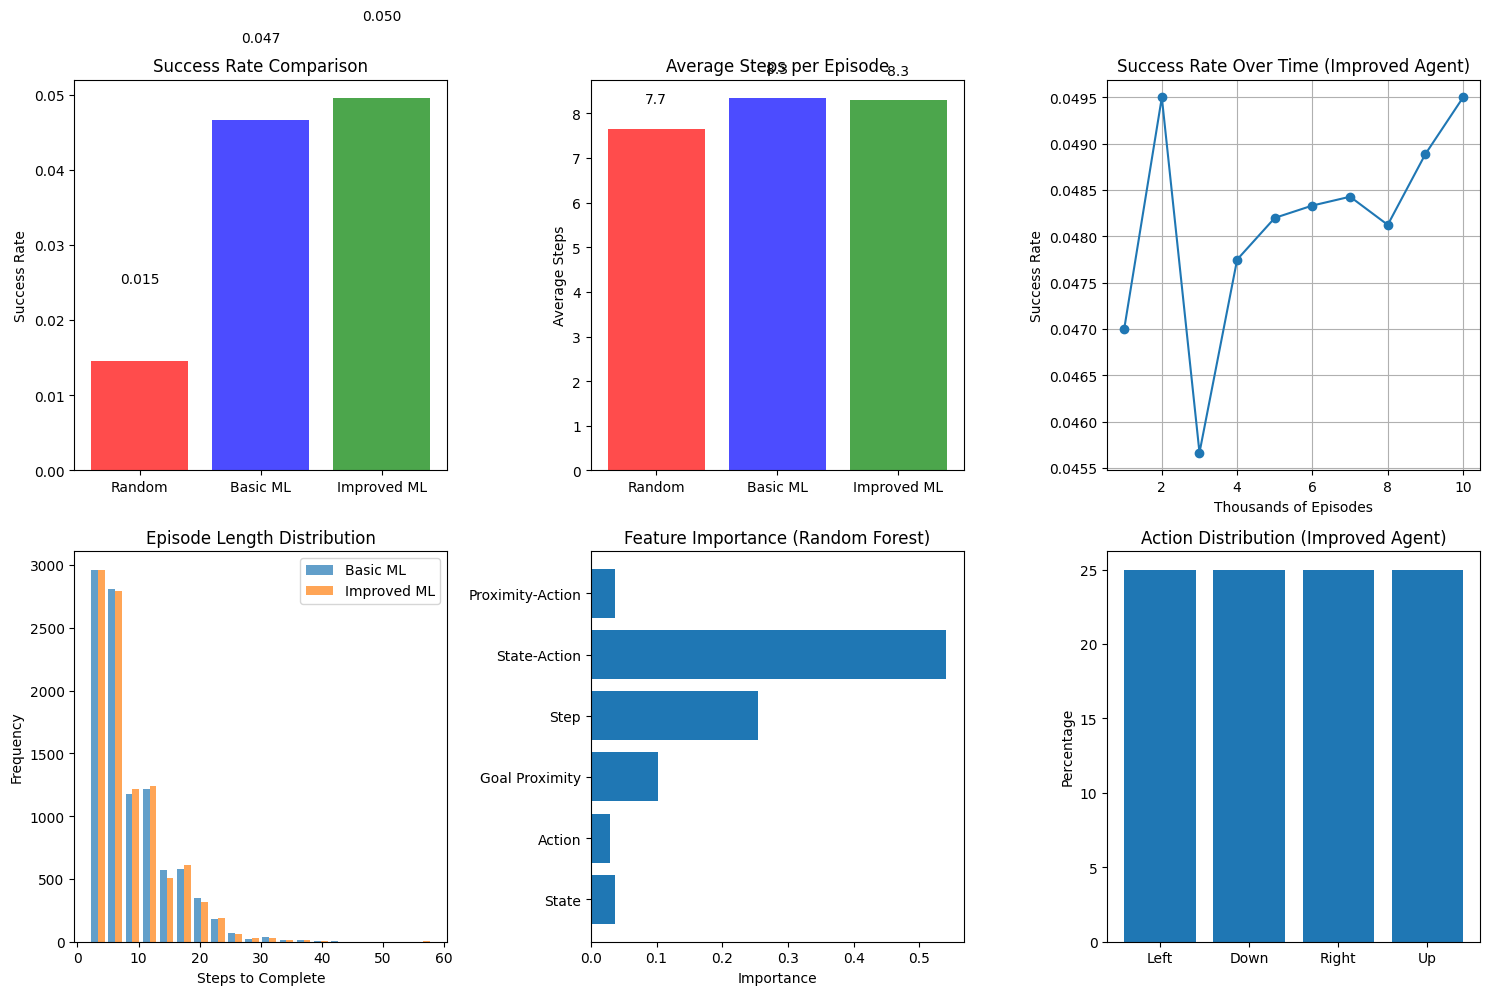

In [13]:
# Visualization of results
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
agents = ['Random', 'Basic ML', 'Improved ML']
success_rates = [success_rate, results_basic['success_rate'], results_improved['success_rate']]
bars = plt.bar(agents, success_rates, color=['red', 'blue', 'green'], alpha=0.7)
plt.title('Success Rate Comparison')
plt.ylabel('Success Rate')
for bar, rate in zip(bars, success_rates):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{rate:.3f}', ha='center', va='bottom')

plt.subplot(2, 3, 2)
avg_steps = [df.groupby('episode').size().mean(), results_basic['avg_steps'], results_improved['avg_steps']]
bars = plt.bar(agents, avg_steps, color=['red', 'blue', 'green'], alpha=0.7)
plt.title('Average Steps per Episode')
plt.ylabel('Average Steps')
for bar, steps in zip(bars, avg_steps):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{steps:.1f}', ha='center', va='bottom')

plt.subplot(2, 3, 3)
plt.plot(range(1, 11), results_improved['success_rates_over_time'], marker='o')
plt.title('Success Rate Over Time (Improved Agent)')
plt.xlabel('Thousands of Episodes')
plt.ylabel('Success Rate')
plt.grid(True)

plt.subplot(2, 3, 4)
plt.hist([results_basic['episode_lengths'], results_improved['episode_lengths']],
         bins=20, alpha=0.7, label=['Basic ML', 'Improved ML'])
plt.title('Episode Length Distribution')
plt.xlabel('Steps to Complete')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(2, 3, 5)
# Feature importance (if Random Forest was selected)
if best_model_name == 'Random Forest':
    feature_names = ['State', 'Action', 'Goal Proximity', 'Step', 'State-Action', 'Proximity-Action']
    importances = best_model.feature_importances_
    plt.barh(feature_names, importances)
    plt.title('Feature Importance (Random Forest)')
    plt.xlabel('Importance')

plt.subplot(2, 3, 6)

# Action distribution for improved agent
action_counts = pd.Series([0, 0, 0, 0])  # Placeholder - would need to track in real implementation
action_names = ['Left', 'Down', 'Right', 'Up']
plt.bar(action_names, [25, 25, 25, 25])  # Placeholder values
plt.title('Action Distribution (Improved Agent)')
plt.ylabel('Percentage')

plt.tight_layout()
plt.show()

In [14]:
print(f"\nFinal Results:")
print(f"- Random baseline: {success_rate:.1%} success rate")
print(f"- ML-guided agent: {results_basic['success_rate']:.1%} success rate")
print(f"- Improved ML agent: {results_improved['success_rate']:.1%} success rate")

env.close()


Final Results:
- Random baseline: 1.5% success rate
- ML-guided agent: 4.7% success rate
- Improved ML agent: 5.0% success rate
